In [88]:
from sklearn.base import BaseEstimator, ClusterMixin
import random
import pandas as pd
import numpy as np
import copy
import types

def get_center_shift(centers, centers_old):
    shift = 0
    for center, center_old in zip(centers, centers_old):
        shift += np.linalg.norm(center - center_old)

    return shift
        
def get_distances(point:list, centers:list):
    distances = []
    for center in centers:
        distances.append(np.linalg.norm(center - point))
    return distances

def run_kmeans(X:list, centers:list, distance_function:types.LambdaType, cluster_iter:int, n_clusters:int, tol:float, verbose:bool):
    
    centers_old = np.zeros(centers.shape)

    labels = np.zeros(len(X))
    labels_old = np.zeros(len(X))
    
    for iter_n in range(cluster_iter):
        for i in range(len(X)):
            distances = distance_function(X[i], centers)
            cluster = np.argmin(distances)
            labels[i] = cluster
        
        for i in range(n_clusters):
            points = [X[j] for j in range(len(X)) if labels[j] == i]
            centers[i] = np.mean(points, axis=0)
        print('iter_n', iter_n)
        print(Counter(labels))
        print(centers)
        if np.array_equal(labels_old, labels):
            if verbose:
                print(f"Converged at iteration {iter_n}: strict convergence.")
            strict_convergence = True
            break
        else:
            center_shift_tot = get_center_shift(centers, centers_old)
            if center_shift_tot <= tol:
                if verbose:
                    print(f"Converged at iteration {iter_n}: center shift "
                          f"{center_shift_tot} within tolerance {tol}.")
                break
                
        centers_old = copy.deepcopy(centers)
        labels_old = copy.deepcopy(labels)
        print()
    return labels, centers

class Custom_Kmeans(BaseEstimator, ClusterMixin):
    
    def __init__(self, n_clusters: int, init:str='random', tol:float=1e-4 , cluster_iter:int=50, verbose:bool=True, distance_function:types.LambdaType=get_distances):
        self.n_clusters = n_clusters
        self.tol = tol
        self.init = init
        self.cluster_iter = cluster_iter
        self.verbose = verbose
        self.distance_function = distance_function
             
    def init_centroids(self, X:list):
        
        if isinstance(self.init, str) and self.init == 'random':
            centers = np.random.permutation(X)[:self.n_clusters]
        else:
            raise Exception('Not implemented')
            
        return centers
            
    def fit(self, X, y=None, sample_weight=None):
        
        centers = self.init_centroids(X)
        labels, centers = run_kmeans(X, centers, self.distance_function, self.cluster_iter, self.n_clusters, self.tol, self.verbose)
        
        self.labels = labels
        self.cluster_centers_ = centers

        return self
    
    def predict(self, X, sample_weight=None):
        pass
        

In [6]:
data = pd.read_csv('../../../Outputs/atenciones_filtradas.csv')

In [81]:
import arcgis
import pandas as pd
from arcgis.gis import GIS

df_routes = []

portal = GIS("https://www.arcgis.com", "dante_rivas_LearnArcGIS", "POSEIDON24")
route = arcgis.network.RouteLayer(portal.properties.helperServices.route.url,
                                          gis=portal)

In [82]:
def get_time_function(route):
    def get_time_distance(point:list, centers:list):
        distances = []
        for center in centers:
            stops = f"{point[1]},{point[0]};{center[1]},{center[0]}"

            result = route.solve(stops=stops,
                                    start_time="now",
                                    return_directions=False,
                                    directions_language="es",)

            time = result['routes']['features'][0]['attributes']['Total_TravelTime']
            distances.append(time)
            
        return distances
    
    return get_time_distance

In [89]:
from collections import Counter
kmeans = Custom_Kmeans(5, distance_function=get_time_function(route))

In [90]:
kmeans.fit(data[['lat', 'lng']].head(100).reset_index(drop=True).values)

iter_n 0
Counter({2.0: 33, 4.0: 29, 0.0: 25, 1.0: 11, 3.0: 2})
[[-12.07333292 -77.03667821]
 [-12.04527982 -76.93043556]
 [-12.12860525 -76.98421781]
 [-12.28097695 -76.86515655]
 [-12.03025883 -77.08702868]]

iter_n 1
Counter({0.0: 35, 2.0: 29, 4.0: 24, 1.0: 10, 3.0: 2})
[[-12.07790414 -77.03896896]
 [-12.04690788 -76.88939419]
 [-12.13208251 -76.99219574]
 [-12.28097695 -76.86515655]
 [-12.01778182 -77.08846807]]

iter_n 2
Counter({0.0: 37, 2.0: 35, 4.0: 22, 1.0: 4, 3.0: 2})
[[-12.0778987  -77.04201494]
 [-11.9888599  -76.8130226 ]
 [-12.1241152  -76.9833008 ]
 [-12.28097695 -76.86515655]
 [-12.01232531 -77.0878452 ]]

iter_n 3
Counter({2.0: 39, 0.0: 35, 4.0: 19, 1.0: 4, 3.0: 3})
[[-12.07584409 -77.05152969]
 [-11.9888599  -76.8130226 ]
 [-12.11772349 -76.98613342]
 [-12.25244973 -76.91099947]
 [-12.00296242 -77.08617093]]

iter_n 4
Counter({2.0: 42, 0.0: 38, 4.0: 13, 1.0: 4, 3.0: 3})
[[-12.07101946 -77.0635635 ]
 [-11.9888599  -76.8130226 ]
 [-12.11716459 -76.9892096 ]
 [-12.2524497

Custom_Kmeans(cluster_iter=50,
              distance_function=<function get_time_function.<locals>.get_time_distance at 0x7fd8f7463e18>,
              init='random', n_clusters=5, tol=0.0001, verbose=True)

In [91]:
kmeans.cluster_centers_

array([[-12.06187154, -77.07367985],
       [-11.9888599 , -76.8130226 ],
       [-12.11299309, -76.99639995],
       [-12.25244973, -76.91099947],
       [-11.93586086, -77.06264972]])

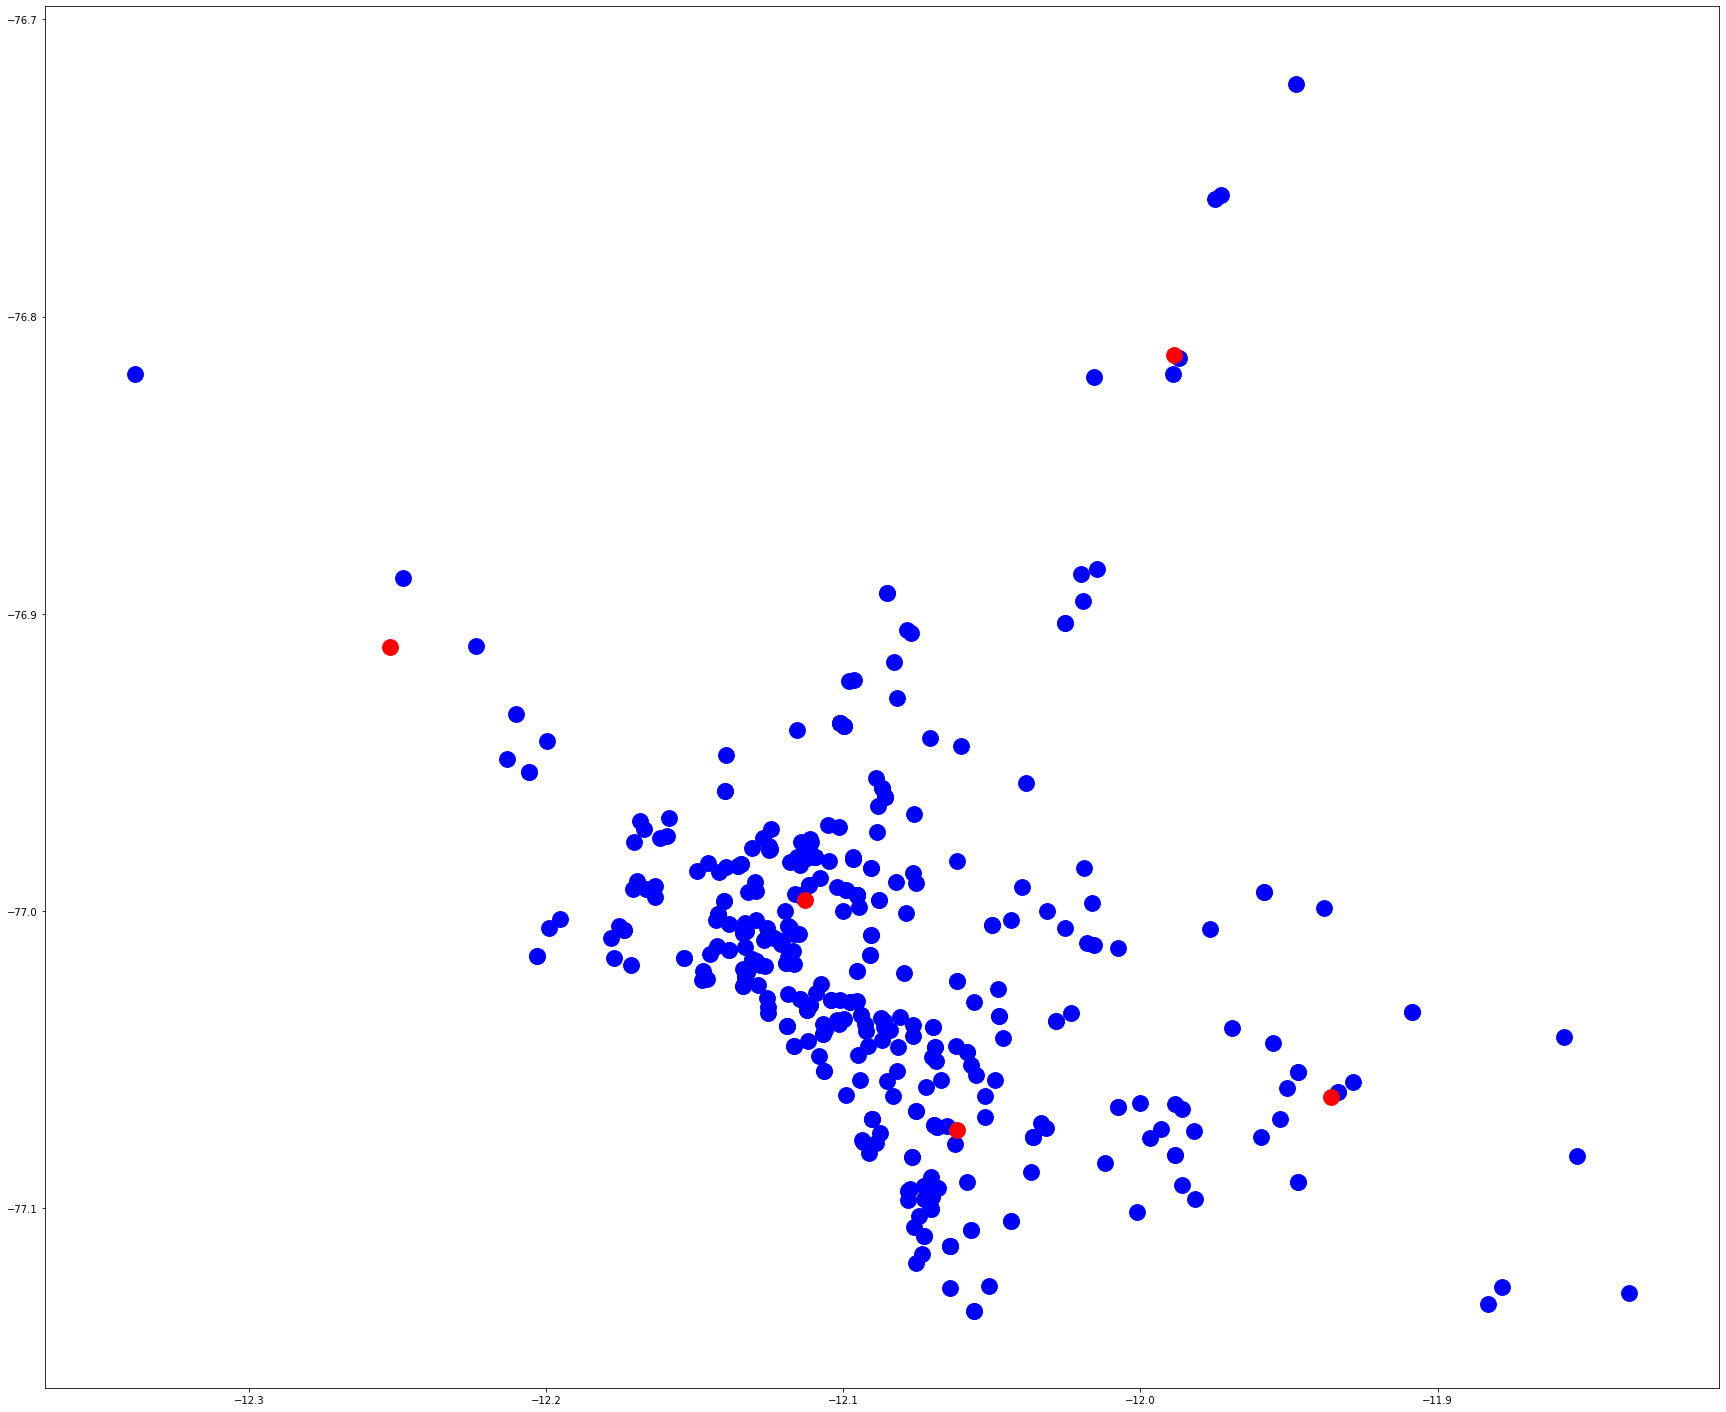

In [94]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(30,30))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=250)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=250)